# Análisis de datos R&D - LHCO 2020

En este notebook intentaremos entender la distribución y relaciones de los datos R&D del LHC Olympics 2020. Los datos se pueden descargar de [este link](https://zenodo.org/record/4536377).
El código está basado en [este notebook](https://github.com/lhcolympics2020/parsingscripts/blob/master/LHCOlympics2020_pyjetexample.ipynb).

In [1]:
# Importamos las librerías a utilizar
import h5py                             # Para manejar los archivos .h5
import numpy as np                      # Manejo de matrices
import matplotlib.pyplot as plt         # Plots
from pyjet import cluster,DTYPE_PTEPM   # Clustering de los jets
import pandas as pd                     # Manejo de tablas
import os.path                          # Manejo de directorios
from os import path

## Lectura de datos

In [2]:
# leemos el archivo como un DataFrame de pandas
df = pd.read_hdf("../events_anomalydetection.h5")

In [3]:
# Vemos que sea del tipo esperado
type(df)

pandas.core.frame.DataFrame

In [4]:
# Vemos como luce el DataFrame
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


El archivo tiene un evento por fila. Cada fila está compuesta por:
- al menos un jet anti-kT R = 1.0 
- con pseudorapidez $|\eta|<2,5$ 
- y momento transversal $pT> 1,2$ TeV. 

Para cada evento, hay una lista de todos los hadrones:

|Evento|$pT$ | $\eta$ | $\phi$ | $pT$ | $\eta$ | $\phi$ | $\cdots$ | Señal? |
|------|-----|--------|--------|------|--------|--------|--------|--------|
| 1    | $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 1.0|
| 2    | $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 0.0|
| $\vdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 0.0|


con relleno de ceros hasta 700 hadrones.


In [5]:
# Sin embargo, tenemos muchos eventos
df.shape

(1100000, 2101)

Haremos la exploración de los datos en un conjunto más pequeño de eventos:

In [6]:
# Para el análisis, escogemos 1000 eventos de la muestra
dfsample = df.sample(n=1000)

In [7]:
# Los guardamos en un archivo .h5 para tener la muestra en la que se haga el análisis
if path.exists("events_anomalydetection_tiny.h5")!= True: 
    dfsample.to_hdf("events_anomalydetection_tiny.h5", key='df', mode='w',complevel=5,complib='blosc')

In [8]:
# Utilizamos estos datos para el análisis
eventos_tiny = pd.read_hdf("events_anomalydetection_tiny.h5")

In [9]:
# Tenemos un dataframe de 
# 1000 eventos x 700 hadrones * 3 características ( pT, eta, phi) + 1 columna (si es señal o fondo)
# El dataframe debe ser 1000x2101

np.shape(eventos_tiny)

(1000, 2101)

La última columna tiene la información sobre si el evento es señal(1) o fondo(0)

In [10]:
eventos_tiny.iloc[:,-1].head()

742939    0.0
101414    1.0
612678    0.0
911510    1.0
738009    0.0
Name: 2100, dtype: float64

La ventaja de tener los datos en un dataframe es que podemos **utilizar la información fácilmente**.

Por ejemplo, para el clustering vamos a utilizar una lista que contenga los pT de cada jet si estos son mayores que 0.

In [11]:
# Por ejemplo, para el primer evento
lista= [data for data in eventos_tiny.iloc[0,::3] if data > 0] # pT, eta, phi, pT... Los pT están cada 3

# Vemos los primeros elementos
lista[0:5]

[0.3853086829185486,
 0.734783947467804,
 0.16018712520599365,
 0.548996090888977,
 0.4115477204322815]

In [12]:
# el largo de cada lista varía según el evento
for evento in range(5):
    lista = [data for data in eventos_tiny.iloc[evento,::3] if data > 0]
    print("largo para evento {}: {}".format(evento+1, len(lista)))

largo para evento 1: 137
largo para evento 2: 91
largo para evento 3: 139
largo para evento 4: 174
largo para evento 5: 148


Podemos hacer dataframes de solamente pT, eta o phi

In [13]:
# pT está cada 3, partiendo de 0.
pt_df = eventos_tiny.iloc[:,::3]

pt_df.head()

,0,3,6,9,12,15,18,21,24,27,...,2073,2076,2079,2082,2085,2088,2091,2094,2097,2100
742939,0.385309,0.734784,0.160187,0.548996,0.411548,0.451372,0.503312,0.435652,1.757613,34.400837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101414,0.367030,0.384321,1.112518,0.492048,0.386599,0.585926,1.204301,3.111389,0.869835,1.558793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
612678,0.502873,0.944979,0.507295,0.600883,1.273456,0.571337,0.696852,1.154837,0.685227,2.060275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
911510,0.730323,36.535522,7.075976,9.440829,74.904274,2.142568,8.071389,1.656551,1.344118,1.566197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
738009,8.290358,10.021173,4.864457,1.623914,21.673780,19.501175,253.132095,55.831982,106.397293,36.680111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Hacemos lo mismo con eta y phi

# Definimos la columna con la información de señal o fondo
senal_column = eventos_tiny[2100]

# Concatenamos esta a los slicing de los dataframe
eta_df = pd.concat([eventos_tiny.iloc[:,1::3],senal_column], axis = 1)
phi_df = pd.concat([eventos_tiny.iloc[:,2::3],senal_column], axis = 1)

### Gráficas

Antes del clustering, podemos graficar la distribución de los datos para cada evento.

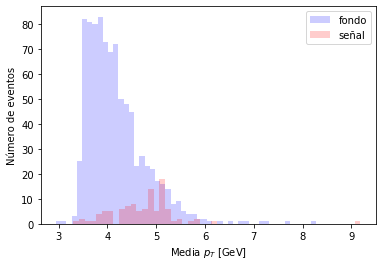

In [15]:
# Distribución de la media de pT para cada evento

# Filtramos que elementos son señal o fondo
pt_senal = pt_df.loc[df[2100] == 1.0]
pt_fondo = pt_df.loc[df[2100] == 0.0]

# Eliminamos la ultima columna de ambos
pt_senal = pt_senal.iloc[:,:-1]
pt_fondo = pt_fondo.iloc[:,:-1]

# Graficamos
fig = plt.figure()
# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)
# Calculamos la media de las filas y hacemos un histograma
pt_fondo.mean(axis=1).plot.hist(bins=50, facecolor='b', alpha=0.2,label='fondo')
pt_senal.mean(axis=1).plot.hist(bins=50, facecolor='r', alpha=0.2,label='señal')
plt.xlabel(r'Media $p_{T}$ [GeV]')
plt.ylabel('Número de eventos')
plt.legend(loc='upper right')
plt.show()
#plt.savefig("leadjetpt.pdf")

Podemos hacer lo mismo para $\eta$ y $\phi$:

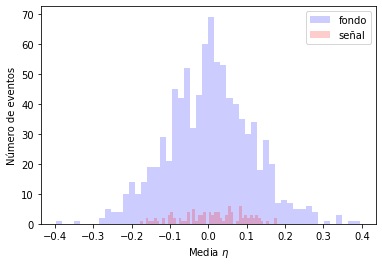

In [16]:
# Distribución de la media de eta para cada evento

# Filtramos que elementos son señal o fondo
eta_senal = eta_df.loc[df[2100] == 1.0]
eta_fondo = eta_df.loc[df[2100] == 0.0]

# Eliminamos la ultima columna de ambos
eta_senal = eta_senal.iloc[:,:-1]
eta_fondo = eta_fondo.iloc[:,:-1]

# Graficamos
fig = plt.figure()
# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)
eta_fondo.mean(axis=1).plot.hist(bins=50, facecolor='b', alpha=0.2,label='fondo')
eta_senal.mean(axis=1).plot.hist(bins=50, facecolor='r', alpha=0.2,label='señal')
plt.xlabel(r'Media $\eta$')
plt.ylabel('Número de eventos')
plt.legend(loc='upper right')
plt.show()
#plt.savefig("leadjetpt.pdf")

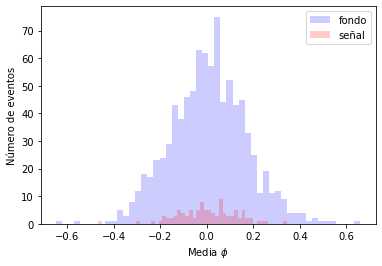

In [17]:
# Distribución de la media de phi para cada evento

# Filtramos que elementos son señal o fondo
phi_senal = phi_df.loc[df[2100] == 1.0]
phi_fondo = phi_df.loc[df[2100] == 0.0]

# Eliminamos la ultima columna de ambos
phi_senal = phi_senal.iloc[:,:-1]
phi_fondo = phi_fondo.iloc[:,:-1]

# Graficamos
fig = plt.figure()
# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)
phi_fondo.mean(axis=1).plot.hist(bins=50, facecolor='b', alpha=0.2,label='fondo')
phi_senal.mean(axis=1).plot.hist(bins=50, facecolor='r', alpha=0.2,label='señal')
plt.xlabel(r'Media $\phi$')
plt.ylabel('Número de eventos')
plt.legend(loc='upper right')
plt.show()
#plt.savefig("leadjetpt.pdf")

## Clustering

Para el clustering vamos a usar la librería <code>pyjet</code>. Esta librería permite hacer el clustering de los jets mediante FastJet y arreglos de NumPy. 

**FastJet** posee 3 clases principales que formarán parte del clustering:
- *PseudoJets*: provee un jet con cuadri-momento y algunos indices internos para situarlo en el contexto de una secuencia de clustering de jets.
- *JetDefinition*: contiene especificaciones sobre cómo se hará el clustering
- *ClusterSequence*: la clase que lleva a cabo el clustering y provee acceso a los jets finales.

Como input tenemos los 1000 eventos con hasta 700 hadrones y como output tendremos:
- Un diccionario con los jets de fondo y de señal en objetos PseudoJets
- Tres diccionario separado en señal y fondo con:
   - $pT$ del jet principal de cada evento
   - $\eta$ del jet principal de cada evento
   - $\phi$ del jet principal de cada evento


El código para el clustering es el siguiente:

In [18]:
# Creamos las variables a utilizar
alljets={}                                     # diccionario con los jets de cada evento y su información
leadpT={}                                      # diccionario de pT del jet principal de cada evento
leadeta={}                                     # diccionario de eta del jet principal de cada evento
leadphi={}                                     # diccionario de phi del jet principal de cada evento
n_eventos = eventos_tiny.shape[0]              # número de eventos (1000)
n_hadrones = int((eventos_tiny.shape[1]-1)/3)  # número de hadrones (700)

print('CLUSTERING DE JETS')
print("En estos datos hay {} eventos y {} hadrones p/evento".format(n_eventos, n_hadrones))

for mitipo in ['fondo','senal']:
    # Creamos el key para cada diccionario 
    alljets[mitipo]=[] 
    leadpT[mitipo]=[]
    leadeta[mitipo]=[]  
    leadphi[mitipo]=[]
    
    for evento in range(n_eventos):
        # Indicamos que el código está corriendo
        if (evento%100==0):
            print(mitipo,evento)
            pass
        
        # La última columna tiene la información sobre si el evento es señal(1) o fondo(0)
        essenal = eventos_tiny.iloc[evento,-1]
        
        # Si estamos en fondo solo analizamos los eventos que son fondo y viceversa.
        if (mitipo=='fondo' and essenal):
            continue
        elif (mitipo=='senal' and essenal==0):
             continue            
            
        # Creamos un numpy array de ceros del tamaño de la cantidad de datos distintos de cero que hay en el evento
        # ** Buscar que es  pyjet DTYPE_PTEPM **
        
        pseudojets_input = np.zeros(len([data for data in eventos_tiny.iloc[evento,::3] if data > 0]), dtype=DTYPE_PTEPM) 
        
        for hadron in range(n_hadrones):
            if (eventos_tiny.iloc[evento,hadron*3]>0): ## si pT > 0 
                
                ## Llenamos el arreglo con pT, eta y phi de cada "partícula"
                pseudojets_input[hadron]['pT'] = eventos_tiny.iloc[evento,hadron*3] 
                pseudojets_input[hadron]['eta'] = eventos_tiny.iloc[evento,hadron*3+1]
                pseudojets_input[hadron]['phi'] = eventos_tiny.iloc[evento,hadron*3+2]
                
                pass
            pass
        
        ## Devuelve una "ClusterSequence" (un tipo de lista de pyjet)
        ## ** No sé en verdad que está haciendo la función. clustering con anti-kt? o con que? que es p? ## 
        secuencia = cluster(pseudojets_input, R=1.0, p=-1) 
        
        ## Con inclusive_jets accedemos a todos los jets que fueron clusterizados
        ## y filtramos los que tienen pT mayor que 20
        ## Hacemos una lista con objetos PseudoJet
        jets = secuencia.inclusive_jets(ptmin=20) 
        
        # Agrega el pT, eta y phi del jet principal
        # ** No sé cómo están en orden **
        leadpT[mitipo] += [jets[0].pt] 
        leadeta[mitipo] += [jets[0].eta] 
        leadphi[mitipo] += [jets[0].phi] 
        
        # agregamos todos los jets a alljets
        alljets[mitipo] += [jets] 
        
        ###################################CHEQUEANDO LOS TIPOS DE VARIABLES#############################################
        if evento==0 or evento==900: 
            print('BREVE ANALISIS DE LAS VARIABLES')
            print('**pseudojets_input**: tipo {}, largo {}'.format(type(pseudojets_input), len(pseudojets_input)))
            print('**secuencia**: tipo {}'.format(type(secuencia)))
            print('**jets**: tipo {}, largo {}, tipo de objetos que contiene {}'.format(type(jets), len(jets), type(jets[0])))
            print('**leadpT**: tipo {}, largo {}, tipo de objeto que contiene {}'.format(type(leadpT), len(leadpT), type(leadpT[mitipo][0])))
            print('**alljets**: tipo {}, largo {}, tipo de objeto que contiene {}'.format(type(alljets), len(alljets), type(alljets[mitipo][0])))
            
        pass        

CLUSTERING DE JETS
En estos datos hay 1000 eventos y 700 hadrones p/evento
fondo 0
BREVE ANALISIS DE LAS VARIABLES
**pseudojets_input**: tipo <class 'numpy.ndarray'>, largo 137
**secuencia**: tipo <class 'pyjet._libpyjet.ClusterSequence'>
**jets**: tipo <class 'list'>, largo 4, tipo de objetos que contiene <class 'pyjet._libpyjet.PseudoJet'>
**leadpT**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'float'>
**alljets**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'list'>
fondo 100
fondo 200
fondo 300
fondo 400
fondo 500
fondo 600
fondo 700
fondo 800
fondo 900
BREVE ANALISIS DE LAS VARIABLES
**pseudojets_input**: tipo <class 'numpy.ndarray'>, largo 102
**secuencia**: tipo <class 'pyjet._libpyjet.ClusterSequence'>
**jets**: tipo <class 'list'>, largo 3, tipo de objetos que contiene <class 'pyjet._libpyjet.PseudoJet'>
**leadpT**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'float'>
**alljets**: tipo <class 'dict'>, largo 1, tipo

### Gráficas

**Graficamos** la distribución de los valores de los jets principales:

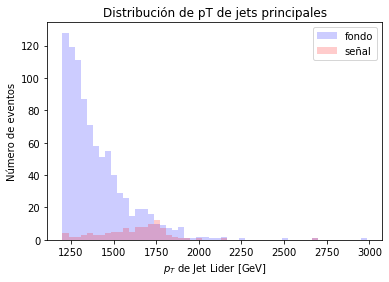

<Figure size 432x288 with 0 Axes>

In [19]:
# Distribución de pT

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadpT['fondo'], bins=50, facecolor='b', alpha=0.2,label='fondo')
plt.hist(leadpT['senal'], bins=b, facecolor='r', alpha=0.2,label='señal')
plt.xlabel(r'$p_{T}$ de Jet Lider [GeV]')
plt.ylabel('Número de eventos')
plt.legend(loc='upper right')
plt.title('Distribución de pT de jets principales')
plt.show()
plt.savefig("leadjetpt.pdf")

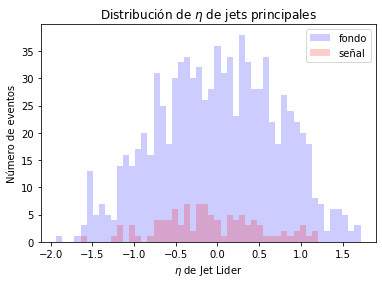

<Figure size 432x288 with 0 Axes>

In [20]:
# Distribución de eta

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadeta['fondo'], bins=50, facecolor='b', alpha=0.2,label='fondo')
plt.hist(leadeta['senal'], bins=b, facecolor='r', alpha=0.2,label='señal')
plt.xlabel(r'$\eta$ de Jet Lider')
plt.ylabel('Número de eventos')
plt.legend(loc='upper right')
plt.title('Distribución de $\eta$ de jets principales')
plt.show()
plt.savefig("leadjeteta.pdf")

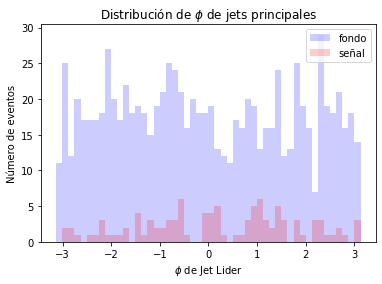

<Figure size 432x288 with 0 Axes>

In [21]:
# Distribución de phi

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadphi['fondo'], bins=50, facecolor='b', alpha=0.2,label='fondo')
plt.hist(leadphi['senal'], bins=b, facecolor='r', alpha=0.2,label='señal')
plt.xlabel(r'$\phi$ de Jet Lider')
plt.ylabel('Número de eventos')
plt.legend(loc='upper right')
plt.title('Distribución de $\phi$ de jets principales')
plt.show()
plt.savefig("leadjetphi.pdf")

Utilizando funciones de FastJet sobre los objetos PseudoJets podemos calcular la masa invariante facilmente:

In [22]:
# MASA INVARIANTE
mjj={}

for mitipo in ['fondo','senal']:
    n_eventos = len(alljets[mitipo])
    mjj[mitipo]=[]
    
    for evento in range(n_eventos): 
        
        jet = alljets[mitipo][evento]
        
        # De cada evento sumamos la energía de los dos jets más energéticos
        E = jet[0].e + jet[1].e
        
        # Igual aqui pero con las componentes del momento
        px = jet[0].px + jet[1].px 
        py = jet[0].py + jet[1].py
        pz = jet[0].pz + jet[1].pz
        
        ## Calculamos la masa invariante
        mjj[mitipo]+=[(E**2-px**2-py**2-pz**2)**0.5] 
        pass
    pass

Y graficamos la distribución

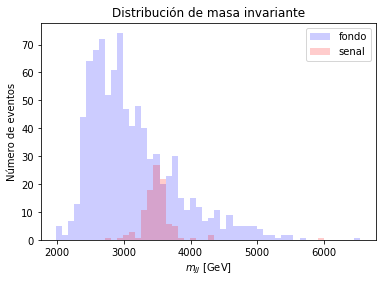

<Figure size 432x288 with 0 Axes>

In [23]:
# Distribución de masa invariante

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(mjj['fondo'], bins=50, facecolor='b', alpha=0.2,label='fondo')
plt.hist(mjj['senal'], bins=b, facecolor='r', alpha=0.2,label='senal')
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Número de eventos')
plt.title('Distribución de masa invariante')
plt.legend(loc='upper right')
plt.show()
plt.savefig("mjj.pdf")

También podemos ver si hay alguna **relación entre las variables**

Text(0, 0.5, '$\\eta$')

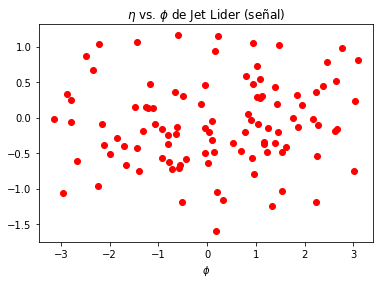

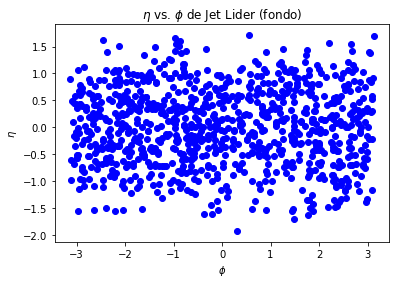

In [24]:
# Relación entre eta y phi

# señal
fig = plt.figure()
plt.scatter(leadphi['senal'], leadeta['senal'], c='r')
plt.title(r'$\eta$ vs. $\phi$ de Jet Lider (señal)')
plt.xlabel(r'$\phi$')

# fondo
fig = plt.figure()
plt.scatter(leadphi['fondo'], leadeta['fondo'], c='b')
plt.title(r'$\eta$ vs. $\phi$ de Jet Lider (fondo)')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\eta$')

Text(0, 0.5, '$\\eta$r')

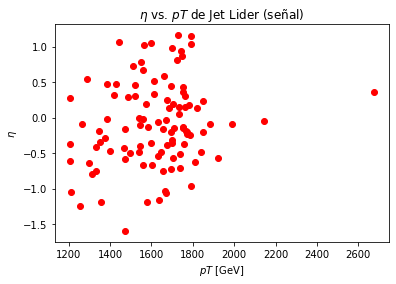

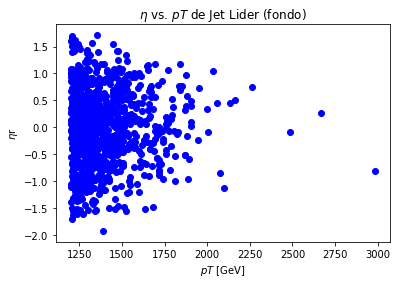

In [25]:
# Relación entre eta y pT

# señal
fig = plt.figure()
plt.scatter(leadpT['senal'], leadeta['senal'], c='r')
plt.title(r'$\eta$ vs. $pT$ de Jet Lider (señal)')
plt.xlabel(r'$pT$ [GeV]')
plt.ylabel(r'$\eta$')

# fondo
fig = plt.figure()
plt.scatter(leadpT['fondo'], leadeta['fondo'], c='b')
plt.title(r'$\eta$ vs. $pT$ de Jet Lider (fondo)')
plt.xlabel(r'$pT$ [GeV]')
plt.ylabel(r'$\eta$r')

Text(0, 0.5, '$\\phi$')

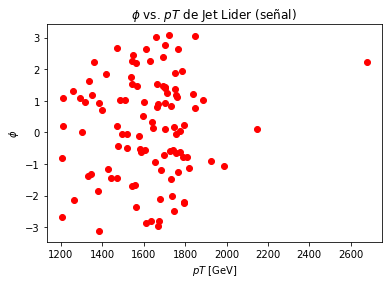

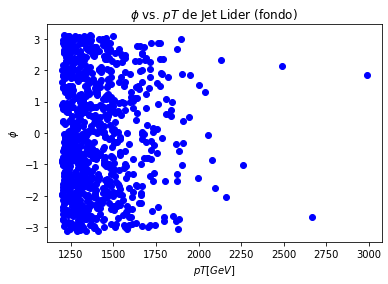

In [26]:
# Relación entre phi y pT

# señal
fig = plt.figure()
plt.scatter(leadpT['senal'], leadphi['senal'], c='r')
plt.title(r'$\phi$ vs. $pT$ de Jet Lider (señal)')
plt.xlabel(r'$pT$ [GeV]')
plt.ylabel(r'$\phi$')

# fondo
fig = plt.figure()
plt.scatter(leadpT['fondo'], leadphi['fondo'], c='b')
plt.title(r'$\phi$ vs. $pT$ de Jet Lider (fondo)')
plt.xlabel(r'$pT [GeV]$ ')
plt.ylabel(r'$\phi$')